In [1]:
from IPython.display import clear_output
clear_output()

In [2]:
# Clone from Github Repository
! git init .
! git remote add origin https://github.com/RichardMinsooGo-ML/Bible_4_Part_M_Semantic_Segmentation.git
# ! git pull origin master
! git pull origin main

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 19 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), 7.99 KiB | 1.60 MiB/s, done.
From https://github.com/RichardMinsooGo-ML/Bible_4_Part_M_Semantic_Segmentation
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [ ]:
import shutil

# Try to remove the tree; if it fails, throw an error using try...except.
try:
    shutil.rmtree("/content/sample_data")
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

In [3]:
# VOC 2012 Dataset Download and extract

! wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf "/content/VOCtrainval_11-May-2012.tar" -C "/content/dataset"
clear_output()

In [4]:
# VOC 2007 Dataset Download and extract

! wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
! wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
!tar -xvf "/content/VOCtrainval_06-Nov-2007.tar" -C "/content/dataset"
!tar -xvf "/content/VOCtest_06-Nov-2007.tar" -C "/content/dataset"
clear_output()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import vgg16

from src.dataset import COLOR_2_INDEX, CLASS_NAMES
from src.utils import batch_mean_iou

from PIL import Image
import glob
from torch.utils.data import Dataset
import torchvision.transforms.functional as TVF

class PascalVoc(Dataset):
    def __init__(self, path, img_size, device="cuda"):
        self.seg_folder = "SegmentationClass/"
        self.img_folder = "JPEGImages/"
        self.path = path
        self.device = device

        self.segmentation_imgs = glob.glob(path + self.seg_folder + "*")
        self.img_size = img_size

    def __len__(self):
        return len(self.segmentation_imgs)

    def get_paths(self, idx):
        mask_path = self.segmentation_imgs[idx]

        # print("mask_path : " , mask_path)

        file_name = mask_path.split("/")[-1]
        img_path = self.path + self.img_folder + file_name
        img_path = img_path.split(".")[0] + ".jpg"

        # print("img_path  : " , img_path)

        return (img_path, mask_path)

    def load_imgs(self, idx):
        img_path, mask_path = self.get_paths(idx)

        img = Image.open(img_path)
        img = img.resize((self.img_size, self.img_size))

        mask_img = Image.open(mask_path).convert("RGB")
        mask_img = mask_img.resize((self.img_size, self.img_size))

        return (img, mask_img)

    @staticmethod
    def create_label_mask(mask_img):
        mask = np.array(mask_img).astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)

        for idx, label in enumerate(COLOR_2_INDEX):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = idx

        label_mask = label_mask.astype(int)
        return label_mask

    def __getitem__(self, idx):
        img, mask_img = self.load_imgs(idx)

        if random.random() > 0.5:
            img = TVF.hflip(img)
            mask_img = TVF.hflip(mask_img)

        mask_img = PascalVoc.create_label_mask(mask_img)
        mask_img = torch.from_numpy(mask_img).long()

        img = TVF.to_tensor(img)
        img = TVF.normalize(img,
                            mean=(0.485, 0.456, 0.406),
                            std=(0.229, 0.224, 0.225)
                           )

        img = img.to(self.device)
        mask_img = mask_img.to(self.device)

        return (img, mask_img)


from pylab import rcParams
%matplotlib inline

path = "dataset/VOCdevkit/VOC2012/"
seed = 42

img_size = 224
device = "cuda"

batch_size = 32
train_dataset = PascalVoc(path, img_size, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0)

class conv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.bn(x)
        return x

class trans_conv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels,
                                       kernel_size=3, stride=2,
                                       padding=1, output_padding=1)

        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.bn(x)
        return x

class u_net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes

        # Indicies used for U-net
        self.un_block_indicies = [(0, 4), (5, 9), (10, 16),
                                   (17, 23), (24, 30)]
        self.init_vgg()

        self.conv_7x7_1 = conv2d(512, 512)
        self.conv_7x7_2 = conv2d(512, 512)

        self.trans_conv_1 = trans_conv2d(512, 256)
        self.trans_conv_2 = trans_conv2d(512, 256)
        self.trans_conv_3 = trans_conv2d(512, 128)
        self.trans_conv_4 = trans_conv2d(256, 64)
        self.trans_conv_5 = trans_conv2d(128, 32)

        self.conv_1 = conv2d(256 + 512, 512)
        self.conv_2 = conv2d(256 + 512, 512)
        self.conv_3 = conv2d(128 + 256, 256)
        self.conv_4 = conv2d(64 + 128, 128)

        self.out_conv = nn.Conv2d(32 + 64, num_classes, stride=1, kernel_size=1)

    def init_vgg(self):
        model = vgg16(pretrained=True)
        del model.classifier
        model = model.to(device)

        self.blocks = []

        for block_idx in self.un_block_indicies:
            self.blocks.append(model.features[block_idx[0]:block_idx[1]])

        # Freezing the VGG weights
        for block in self.blocks:
            for param in block.parameters():
                param.requires_grad = False

    def forward(self, x):
        x_1 = self.blocks[0](x)
        encoder = F.max_pool2d(x_1, kernel_size=2, stride=2)
        x_2 = self.blocks[1](encoder)
        encoder = F.max_pool2d(x_2, kernel_size=2, stride=2)
        x_3 = self.blocks[2](encoder)
        encoder = F.max_pool2d(x_3, kernel_size=2, stride=2)
        x_4 = self.blocks[3](encoder)
        encoder = F.max_pool2d(x_4, kernel_size=2, stride=2)
        x_5 = self.blocks[4](encoder)
        encoder = F.max_pool2d(x_5, kernel_size=2, stride=2)

        encoder = self.conv_7x7_1(encoder)
        encoder = self.conv_7x7_2(encoder)

        decoder = self.trans_conv_1(encoder)
        decoder = torch.cat((decoder, x_5), dim=1)
        decoder = self.conv_1(decoder)

        decoder = self.trans_conv_2(decoder)
        decoder = torch.cat((decoder, x_4), dim=1)
        decoder = self.conv_2(decoder)

        decoder = self.trans_conv_3(decoder)
        decoder = torch.cat((decoder, x_3), dim=1)
        decoder = self.conv_3(decoder)

        decoder = self.trans_conv_4(decoder)
        decoder = torch.cat((decoder, x_2), dim=1)
        decoder = self.conv_4(decoder)

        decoder = self.trans_conv_5(decoder)
        decoder = torch.cat((decoder, x_1), dim=1)
        decoder = self.out_conv(decoder)

        score = F.log_softmax(decoder, dim=1)
        return score

torch.manual_seed(seed)
model = u_net(len(CLASS_NAMES)).to(device)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 199MB/s]


In [6]:

num_epochs = 40

lr = 2e-3
wd = 1e-5
gamma = 0.5
step_size = 10

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
loss_fct = nn.NLLLoss()

from tqdm import tqdm, tqdm_notebook, trange

torch.manual_seed(seed)
model.train()
for epoch in range(1, num_epochs+1):
    loss = 0.0
    iou = 0.0

    scheduler.step()

    with tqdm_notebook(total=len(train_dataloader), desc=f"Train {epoch+1}") as pbar:

        for _, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()

            y_hat = model(x)
            batch_loss = loss_fct(y_hat, y)

            batch_loss.backward()
            optimizer.step()

            batch_loss = batch_loss.detach().cpu().numpy()
            loss += batch_loss

            preds = torch.argmax(y_hat, dim=1)
            batch_iou = batch_mean_iou(preds.detach().cpu().numpy(), y.detach().cpu().numpy())
            iou += batch_iou

            pbar.update(1)

    loss = loss / len(train_dataloader)
    iou = iou / len(train_dataloader)

    if (epoch+1) % 5 == 0:
        print(f"-------Epoch {epoch+1}-------")
        print(f"Loss : {loss}")
        print(f"Mean IOU: {iou}")


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-6-3074ef5681bc>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=len(train_dataloader), desc=f"Train {epoch+1}") as pbar:


Train 2:   0%|          | 0/92 [00:00<?, ?it/s]

Train 3:   0%|          | 0/92 [00:00<?, ?it/s]

Train 4:   0%|          | 0/92 [00:00<?, ?it/s]

Train 5:   0%|          | 0/92 [00:00<?, ?it/s]

-------Epoch 5-------
Loss : 0.4634158669606499
Mean IOU: 0.5887297393247356


Train 6:   0%|          | 0/92 [00:00<?, ?it/s]

Train 7:   0%|          | 0/92 [00:00<?, ?it/s]

Train 8:   0%|          | 0/92 [00:00<?, ?it/s]

Train 9:   0%|          | 0/92 [00:00<?, ?it/s]

Train 10:   0%|          | 0/92 [00:00<?, ?it/s]

-------Epoch 10-------
Loss : 0.2449548921507338
Mean IOU: 0.7121988460828345


Train 11:   0%|          | 0/92 [00:00<?, ?it/s]

Train 12:   0%|          | 0/92 [00:00<?, ?it/s]

Train 13:   0%|          | 0/92 [00:00<?, ?it/s]

Train 14:   0%|          | 0/92 [00:00<?, ?it/s]

Train 15:   0%|          | 0/92 [00:00<?, ?it/s]

-------Epoch 15-------
Loss : 0.11661824754074863
Mean IOU: 0.8068626825195749


Train 16:   0%|          | 0/92 [00:00<?, ?it/s]

Train 17:   0%|          | 0/92 [00:00<?, ?it/s]

Train 18:   0%|          | 0/92 [00:00<?, ?it/s]

Train 19:   0%|          | 0/92 [00:00<?, ?it/s]

Train 20:   0%|          | 0/92 [00:00<?, ?it/s]

-------Epoch 20-------
Loss : 0.08905288366519887
Mean IOU: 0.8317563256864206


Train 21:   0%|          | 0/92 [00:00<?, ?it/s]

Train 22:   0%|          | 0/92 [00:00<?, ?it/s]

Train 23:   0%|          | 0/92 [00:00<?, ?it/s]

Train 24:   0%|          | 0/92 [00:00<?, ?it/s]

Train 25:   0%|          | 0/92 [00:00<?, ?it/s]

-------Epoch 25-------
Loss : 0.055897769659919584
Mean IOU: 0.8713297450362895


Train 26:   0%|          | 0/92 [00:00<?, ?it/s]

Train 27:   0%|          | 0/92 [00:00<?, ?it/s]

Train 28:   0%|          | 0/92 [00:00<?, ?it/s]

Train 29:   0%|          | 0/92 [00:00<?, ?it/s]

Train 30:   0%|          | 0/92 [00:00<?, ?it/s]

-------Epoch 30-------
Loss : 0.052574410325969045
Mean IOU: 0.87659324679526


Train 31:   0%|          | 0/92 [00:00<?, ?it/s]

Train 32:   0%|          | 0/92 [00:00<?, ?it/s]

Train 33:   0%|          | 0/92 [00:00<?, ?it/s]

Train 34:   0%|          | 0/92 [00:00<?, ?it/s]

Train 35:   0%|          | 0/92 [00:00<?, ?it/s]

-------Epoch 35-------
Loss : 0.03872026639747555
Mean IOU: 0.8981538310442126


Train 36:   0%|          | 0/92 [00:00<?, ?it/s]

Train 37:   0%|          | 0/92 [00:00<?, ?it/s]

Train 38:   0%|          | 0/92 [00:00<?, ?it/s]

Train 39:   0%|          | 0/92 [00:00<?, ?it/s]

Train 40:   0%|          | 0/92 [00:00<?, ?it/s]

-------Epoch 40-------
Loss : 0.03587597618689355
Mean IOU: 0.9039333717445747


Train 41:   0%|          | 0/92 [00:00<?, ?it/s]

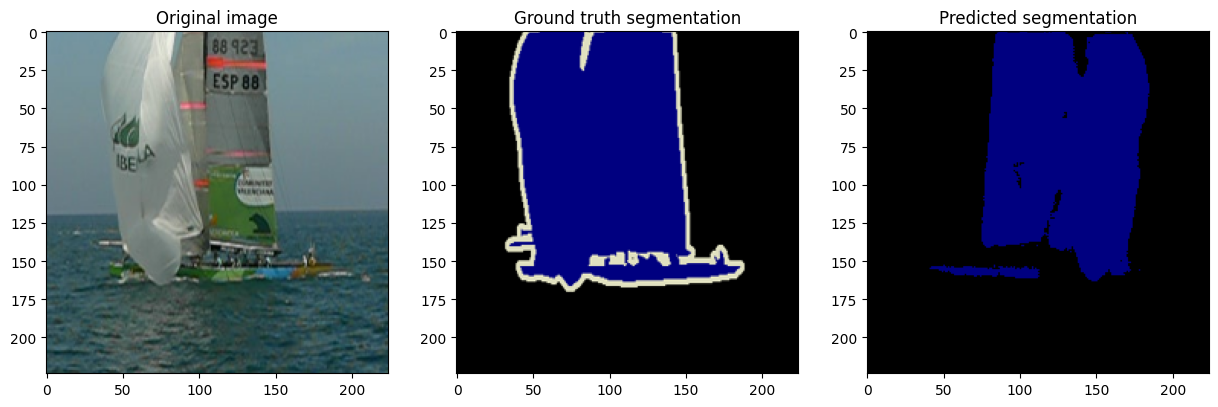

In [7]:
random.seed(seed)
model.eval()

idx = 3
x, _ = train_dataset[idx]
y, _ = train_dataset.load_imgs(idx)
gt = train_dataset.segmentation_imgs[idx]
gt = Image.open(gt).convert("RGB")

x = x.unsqueeze(0)
y_hat = model(x)
y_hat = torch.argmax(y_hat, dim=1)[0, :, :]
y_hat = y_hat.detach().cpu().numpy()

gt = gt.resize((img_size, img_size))
gt = np.array(gt)

y_hat_mask = np.zeros((img_size, img_size, 3))

for i in range(img_size):
    for j in range(img_size):
        y_hat_mask[i, j, :] = COLOR_2_INDEX[y_hat[i, j]]

y_hat_mask = y_hat_mask.astype(int)

rcParams['figure.figsize'] = 15, 15

plt.subplot(1, 3, 1)
plt.imshow(y)
plt.title("Original image")

plt.subplot(1, 3, 2)
plt.imshow(gt)
plt.title("Ground truth segmentation")

plt.subplot(1, 3, 3)
plt.imshow(y_hat_mask)
plt.title("Predicted segmentation")

plt.show()

